In [3]:
# # Install required libraries
#%pip install matplotlib pandas numpy seaborn plotly

In [4]:
# %cd /content/drive/MyDrive/FireShield360/analysis/data

In [5]:
!matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
import os
import warnings
import plotly.express as px
import plotly.io as pio

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


# pio.renderers.default = "colab"
pio.renderers.default = "vscode"      # <- the VS Code renderer
# pio.renderers.default = "notebook"  # works too; loads plotly.js inline
# pio.renderers.default = "iframe"    # good for static HTML export

# Set plot styling and suppress warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 12

'matplotlib' is not recognized as an internal or external command,
operable program or batch file.


## 2. Data Loading and Preparation

Load the sensor data from CSV, convert timestamps to datetime format, and prepare the data for time-series analysis.

In [6]:
# # Define the data file path
# file_path = os.path.join('data', 'sensor_readings_export_20250426_132445.csv')

# Load the data
df0 = pd.read_csv('../data/raw/sensor_readings_export_20250429_200406.csv')

# Display the first few rows to understand the data structure
print(f"Data shape: {df0.shape}")
df0.head()

Data shape: (428768, 11)


_id  temperature  humidity  smoke  \
0  6804fffa239fbf0170b04a6a         34.7        71   1685   
1  6804fffb239fbf0170b04a6b         34.7        71   1687   
2  6804fffc239fbf0170b04a6c         34.9        71   1690   
3  6804fffd239fbf0170b04a6d         34.9        71   1680   
4  6804fffe239fbf0170b04a6e         34.1        71   1692   

                  timestamp device_id smoke_detected wildfire_detected  \
0  2025-04-20T19:38:59+05:3  esp32_01            NaN               NaN   
1  2025-04-20T19:39:00+05:3  esp32_01            NaN               NaN   
2  2025-04-20T19:39:01+05:3  esp32_01            NaN               NaN   
3  2025-04-20T19:39:02+05:3  esp32_01            NaN               NaN   
4  2025-04-20T19:39:03+05:3  esp32_01            NaN               NaN   

   thresholds_exceeded  ir_temperature potential_wildfire  
0                  NaN             NaN                NaN  
1                  NaN             NaN                NaN  
2                  NaN             NaN                NaN  
3                  NaN             NaN                NaN  
4                  NaN             NaN                NaN

In [7]:
# Check unique device IDs in the dataset
unique_devices = df0['device_id'].unique()
print(f"Unique device IDs in the dataset: {unique_devices}")

Unique device IDs in the dataset: ['esp32_01']


In [8]:
# Filter the dataset to only include records from device_id 'esp32_01'
df0 = df0[df0['device_id'] == 'esp32_01']

# Display first few rows of the filtered dataset
df0.head()

_id  temperature  humidity  smoke  \
0  6804fffa239fbf0170b04a6a         34.7        71   1685   
1  6804fffb239fbf0170b04a6b         34.7        71   1687   
2  6804fffc239fbf0170b04a6c         34.9        71   1690   
3  6804fffd239fbf0170b04a6d         34.9        71   1680   
4  6804fffe239fbf0170b04a6e         34.1        71   1692   

                  timestamp device_id smoke_detected wildfire_detected  \
0  2025-04-20T19:38:59+05:3  esp32_01            NaN               NaN   
1  2025-04-20T19:39:00+05:3  esp32_01            NaN               NaN   
2  2025-04-20T19:39:01+05:3  esp32_01            NaN               NaN   
3  2025-04-20T19:39:02+05:3  esp32_01            NaN               NaN   
4  2025-04-20T19:39:03+05:3  esp32_01            NaN               NaN   

   thresholds_exceeded  ir_temperature potential_wildfire  
0                  NaN             NaN                NaN  
1                  NaN             NaN                NaN  
2                  NaN             NaN                NaN  
3                  NaN             NaN                NaN  
4                  NaN             NaN                NaN

### 2.1 Data Cleaning and Preprocessing

In [9]:
# Check data types
print("\nData types:")
print(df0.dtypes)


Data types:
_id                     object
temperature            float64
humidity                 int64
smoke                    int64
timestamp               object
device_id               object
smoke_detected          object
wildfire_detected       object
thresholds_exceeded    float64
ir_temperature         float64
potential_wildfire      object
dtype: object


In [10]:
# Check for missing values
print("Missing values per column:")
print(df0.isnull().sum())

Missing values per column:
_id                         0
temperature                 0
humidity                    0
smoke                       0
timestamp                   0
device_id                   0
smoke_detected         425375
wildfire_detected      355842
thresholds_exceeded    423101
ir_temperature           6817
potential_wildfire      74112
dtype: int64


In [11]:
# Drop specified columns
df1 = df0.drop(['smoke_detected', 'wildfire_detected', 'thresholds_exceeded', 'potential_wildfire', 'device_id', '_id'], axis=1)

# Display the updated DataFrame info
print("Updated DataFrame columns:")
print(df1.columns.tolist())

Updated DataFrame columns:
['temperature', 'humidity', 'smoke', 'timestamp', 'ir_temperature']


In [12]:
df1.head()

temperature  humidity  smoke                 timestamp  ir_temperature
0         34.7        71   1685  2025-04-20T19:38:59+05:3             NaN
1         34.7        71   1687  2025-04-20T19:39:00+05:3             NaN
2         34.9        71   1690  2025-04-20T19:39:01+05:3             NaN
3         34.9        71   1680  2025-04-20T19:39:02+05:3             NaN
4         34.1        71   1692  2025-04-20T19:39:03+05:3             NaN

In [13]:
# Check for missing values
print("Missing values per column:")
print(df1.isnull().sum())

Missing values per column:
temperature          0
humidity             0
smoke                0
timestamp            0
ir_temperature    6817
dtype: int64


In [14]:
# Create a clean copy of the data for our analysis
df2 = df1.copy()

# Remove rows where ir_temperature is missing
df3 = df2.dropna(subset=['ir_temperature'])

# Check the shape after removing rows with missing ir_temperature
print(f"Data shape after removing rows with missing ir_temperature: {df3.shape}")

# Check for missing values in the remaining data
print("\nMissing values after cleaning:")
print(df3.isnull().sum())

Data shape after removing rows with missing ir_temperature: (421951, 5)

Missing values after cleaning:
temperature       0
humidity          0
smoke             0
timestamp         0
ir_temperature    0
dtype: int64


In [15]:
# Display the cleaned data
print("After cleaning:")
print(f"Data shape: {df3.shape}")

# Display a few rows of the cleaned data
df3.head()

After cleaning:
Data shape: (421951, 5)


temperature  humidity  smoke                 timestamp  ir_temperature
6792         34.5        67   1451  2025-04-21T19:27:51+05:3        31.67001
6793         34.5        67   1467  2025-04-21T19:27:52+05:3        31.63000
6794         34.3        67   1447  2025-04-21T19:27:53+05:3        31.67001
6795         34.3        67   1471  2025-04-21T19:27:54+05:3        31.67001
6796         34.0        67   1454  2025-04-21T19:27:55+05:3        31.67001

In [16]:
# Convert timestamp to datetime (force UTC to handle tz‑aware strings)
df3['timestamp'] = pd.to_datetime(df3['timestamp'], utc=True)

# (Optional) Drop the timezone info to get naive datetimes
df3['timestamp'] = df3['timestamp'].dt.tz_convert(None)

# Now filter years > 2025
df3 = df3[df3['timestamp'].dt.year >= 2025]

In [17]:
df3

temperature  humidity  smoke           timestamp  ir_temperature
6792           34.5        67   1451 2025-04-21 14:24:51        31.67001
6793           34.5        67   1467 2025-04-21 14:24:52        31.63000
6794           34.3        67   1447 2025-04-21 14:24:53        31.67001
6795           34.3        67   1471 2025-04-21 14:24:54        31.67001
6796           34.0        67   1454 2025-04-21 14:24:55        31.67001
...             ...       ...    ...                 ...             ...
428763         32.0        80   2191 2025-04-29 15:02:18        30.42999
428764         32.1        80   2191 2025-04-29 15:02:19        30.42999
428765         32.1        80   2190 2025-04-29 15:02:20        30.45001
428766         32.0        80   2192 2025-04-29 15:02:21        30.51000
428767         32.0        80   2187 2025-04-29 15:02:22        30.47000

[420429 rows x 5 columns]

In [18]:
# Set timestamp as index for time-series analysis
df3.set_index('timestamp', inplace=True)

# Convert numerical columns to float
numerical_columns = ['temperature', 'humidity', 'smoke', 'ir_temperature']
for col in numerical_columns:
    if col in df3.columns:
        df3[col] = pd.to_numeric(df3[col], errors='coerce')

# Handle missing values by filling with column means
df3[numerical_columns] = df3[numerical_columns].fillna(df3[numerical_columns].mean())

# Display the cleaned data
print("After cleaning:")
print(f"Data shape: {df3.shape}")
df3.head()

After cleaning:
Data shape: (420429, 4)


temperature  humidity  smoke  ir_temperature
timestamp                                                        
2025-04-21 14:24:51         34.5        67   1451        31.67001
2025-04-21 14:24:52         34.5        67   1467        31.63000
2025-04-21 14:24:53         34.3        67   1447        31.67001
2025-04-21 14:24:54         34.3        67   1471        31.67001
2025-04-21 14:24:55         34.0        67   1454        31.67001

### 2.2 Removing Data Points Based on Thresholds

Let's remove data points that fall below certain thresholds which may indicate sensor errors or irrelevant conditions for wildfire analysis:

In [19]:
# Display shape before filtering
print(f"Data shape before filtering: {df3.shape}")

# Store original DataFrame for reference
df_original = df3.copy()

# Filter out rows with values below thresholds
filtered_df = df3[
    (df3['temperature'] > 30) &
    (df3['humidity'] > 10) &
    (df3['smoke'] > 1000) &
    (df3['ir_temperature'] > 20)
]

# Reassign filtered DataFrame to df3 for subsequent analysis
df4 = filtered_df.copy()

# Display the results of filtering
print(f"Data shape after filtering: {df4.shape}")
print(f"Removed {df3.shape[0] - df4.shape[0]} rows based on threshold conditions")

# Display percentage of data retained
retention_percentage = (df4.shape[0] / df3.shape[0]) * 100
print(f"Retained {retention_percentage:.2f}% of the original data after filtering")

# Display first few rows of filtered data
df4.head()

Data shape before filtering: (420429, 4)
Data shape after filtering: (413006, 4)
Removed 7423 rows based on threshold conditions
Retained 98.23% of the original data after filtering


temperature  humidity  smoke  ir_temperature
timestamp                                                        
2025-04-21 14:24:51         34.5        67   1451        31.67001
2025-04-21 14:24:52         34.5        67   1467        31.63000
2025-04-21 14:24:53         34.3        67   1447        31.67001
2025-04-21 14:24:54         34.3        67   1471        31.67001
2025-04-21 14:24:55         34.0        67   1454        31.67001

### 2.3 Data Processing Flow

For clarity, here's a summary of our data processing pipeline:

1. **Initial Load**: Loaded raw sensor data from CSV file
2. **Device Filtering**: Selected only data from device 'esp32_01'
3. **Column Reduction**: Removed non-essential columns
4. **Missing Value Handling**: Removed rows with missing IR temperature values
5. **Timestamp Conversion**: Converted timestamps to datetime format
6. **Normalization**: Ensured numerical data types for sensor readings
7. **Threshold Filtering**: Applied minimum thresholds to filter out irrelevant data

This clean, time-indexed dataset (df4) will be the foundation for all subsequent analyses.

## 3. Basic Statistical Summary

Let's examine the basic statistics of our sensor data to understand the distribution.

In [20]:
# Generate descriptive statistics
df4[numerical_columns].describe()

temperature       humidity          smoke  ir_temperature
count  413006.000000  413006.000000  413006.000000   413006.000000
mean       32.220342      78.449524    1533.315315       31.257732
std         1.289519       3.926046     248.174892        2.942589
min        30.100000      11.000000    1003.000000       20.149990
25%        31.300000      76.000000    1383.000000       29.230010
50%        32.100000      79.000000    1484.000000       30.429990
75%        33.100000      81.000000    1590.000000       33.110010
max        40.900000      88.000000    4095.000000      224.150000

## 4. Temporal Pattern Analysis

In this section, we'll analyze how sensor readings change over time, looking at both daily patterns and longer-term trends. This will help identify periods of higher wildfire risk and understand the environmental factors that contribute to those risks.

### 4.1 Sensor Data Time Series Overview

First, let's visualize the overall trends in our key sensor readings across the entire dataset period.

### 4.2 Daily Patterns Analysis

Let's extract the hour of day to analyze daily patterns.

In [21]:
# Filter data for dates after April 25, 2025
df5 = df4[(df4.index >= '2025-04-25')]

# Display basic information about the filtered dataset
print(f"Original data shape: {df4.shape}")
print(f"Filtered data shape: {df5.shape}")
print("\nDate range in filtered data:")
print(f"Start: {df5.index.min()}")
print(f"End: {df5.index.max()}")

Original data shape: (413006, 4)
Filtered data shape: (347299, 4)

Date range in filtered data:
Start: 2025-04-25 04:15:00
End: 2025-04-29 15:02:22


In [22]:
df5

temperature  humidity  smoke  ir_temperature
timestamp                                                        
2025-04-25 04:15:00         30.7        87   2241        33.86999
2025-04-25 04:15:01         30.4        87   2235        33.83001
2025-04-25 04:15:02         30.4        87   2235        33.83001
2025-04-25 04:15:03         30.6        87   2234        33.91000
2025-04-25 04:15:04         30.6        87   2236        33.83001
...                          ...       ...    ...             ...
2025-04-29 15:02:18         32.0        80   2191        30.42999
2025-04-29 15:02:19         32.1        80   2191        30.42999
2025-04-29 15:02:20         32.1        80   2190        30.45001
2025-04-29 15:02:21         32.0        80   2192        30.51000
2025-04-29 15:02:22         32.0        80   2187        30.47000

[347299 rows x 4 columns]

In [23]:
# Resample data to 1-minute intervals to reduce noise while maintaining temporal detail
# This provides a good balance for time series visualization and pattern recognition
df5_downsampled = df5.resample('1T').mean()

# Display basic info about the resampled data
print(f"Original data points: {df5.shape[0]}")
print(f"Resampled data points: {df5_downsampled.shape[0]}")
print(f"Reduction ratio: {df5_downsampled.shape[0]/df5.shape[0]:.2%}")

Original data points: 347299
Resampled data points: 6408
Reduction ratio: 1.85%


### 4.2.1 Individual Sensor Visualizations

Below we plot each sensor's readings over the course of April 25, 2025. These visualizations help identify how different environmental factors change throughout the day and may reveal patterns related to wildfire risk.

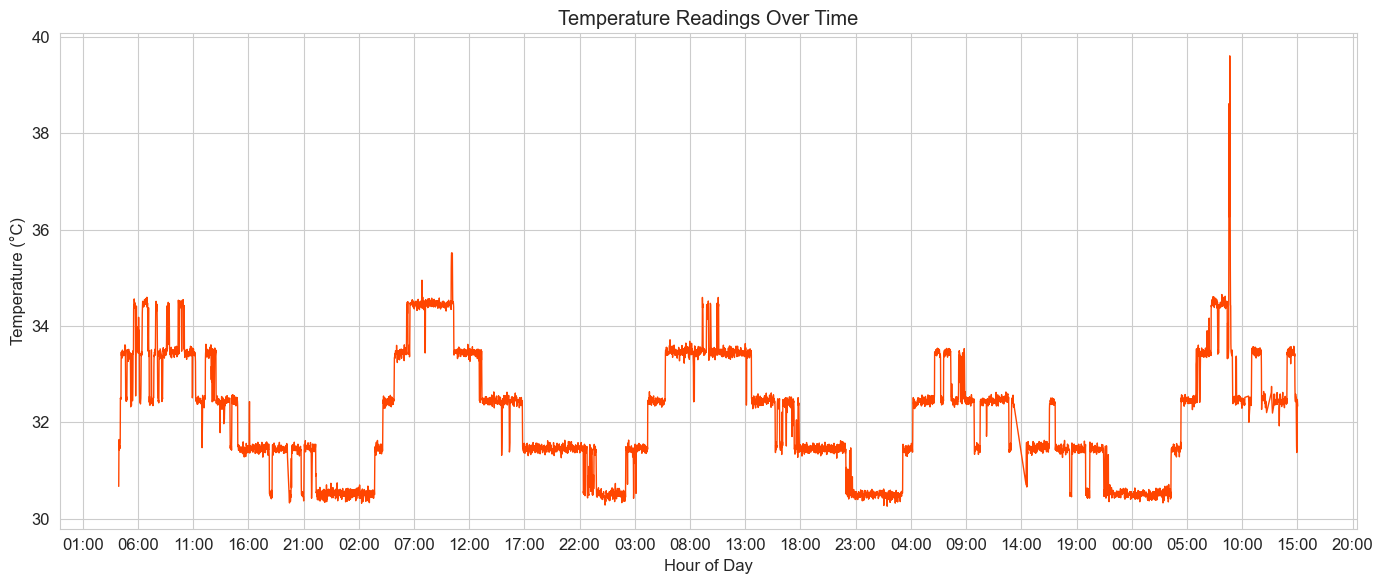

In [24]:
# 3. Plot
plt.figure(figsize=(14, 6))
ax = sns.lineplot(
    x=df5_downsampled.index,
    y=df5_downsampled['temperature'],
    color='orangered',
    linewidth=1
)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=5))
plt.title('Temperature Readings Over Time')
plt.xlabel('Hour of Day')
plt.ylabel('Temperature (°C)')
plt.tight_layout()
plt.show()


In [25]:
fig = px.line(
    df5_downsampled,
    x=df5_downsampled.index,
    y="temperature",
    labels={"temperature": "Temperature (°C)", "index": "Time"},
    title="Temperature Readings Over Time"
)
fig.show()

In [26]:
fig = px.line(
    df5_downsampled,
    x=df5_downsampled.index,
    y="smoke",
    labels={"smoke": "Smoke (°C)", "index": "Time"},
    title="Smoke Readings Over Time"
)
fig.show()

In [27]:
fig = px.line(
    df5_downsampled,
    x=df5_downsampled.index,
    y="humidity",
    labels={"humidity": "Humidity (°C)", "index": "Time"},
    title="Humidity Readings Over Time"
)
fig.show()

In [28]:
fig = px.line(
    df5_downsampled,
    x=df5_downsampled.index,
    y="ir_temperature",
    labels={"ir_temperature": "Inferred Temperature (°C)", "index": "Time"},
    title="Inferred Temperature Readings Over Time"
)
fig.show()

In [29]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Create a 2x2 grid of subplots
fig = make_subplots(
    rows=4,
    cols=1,
    subplot_titles=(
        "Temperature Readings",
        "IR Temperature Readings"
        "Humidity Readings",
        "Smoke Readings",
    )
)

# Add traces for each sensor
fig.add_trace(
    go.Scatter(
        x=df5_downsampled.index,
        y=df5_downsampled["temperature"],
        name="Temperature"
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=df5_downsampled.index,
        y=df5_downsampled["ir_temperature"],
        name="IR Temperature"
    ),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(
        x=df5_downsampled.index,
        y=df5_downsampled["humidity"],
        name="Humidity"
    ),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(
        x=df5_downsampled.index,
        y=df5_downsampled["smoke"],
        name="Smoke"
    ),
    row=4, col=1
)



# Update layout
fig.update_layout(
    height=800,
    width=1000,
    title_text="Sensor Readings Over Time (April 25, 2025)",
    showlegend=True
)

# Update y-axis labels
fig.update_yaxes(title_text="Temperature (°C)", row=1, col=1)
fig.update_yaxes(title_text="IR Temperature (°C)", row=2, col=1)
fig.update_yaxes(title_text="Humidity (%)", row=3, col=1)
fig.update_yaxes(title_text="Smoke Level", row=4, col=1)

fig.show()

### 4.3 Daily Aggregations

Resample the data to see daily patterns and trends.

## 5. Correlation Analysis Between Sensors

Analyze how different sensors relate to each other over time.

### 5.1 Understanding Sensor Correlations

The correlation heatmap below provides insights into how different environmental factors interact with each other in our monitoring system:

- **Positive correlations** indicate sensors that tend to increase together
- **Negative correlations** indicate that when one sensor reading increases, the other tends to decrease
- **Strong correlations** (closer to 1 or -1) indicate a more reliable relationship between sensor readings

These relationships are particularly valuable for identifying key indicators and potential redundancies in our wildfire detection system.

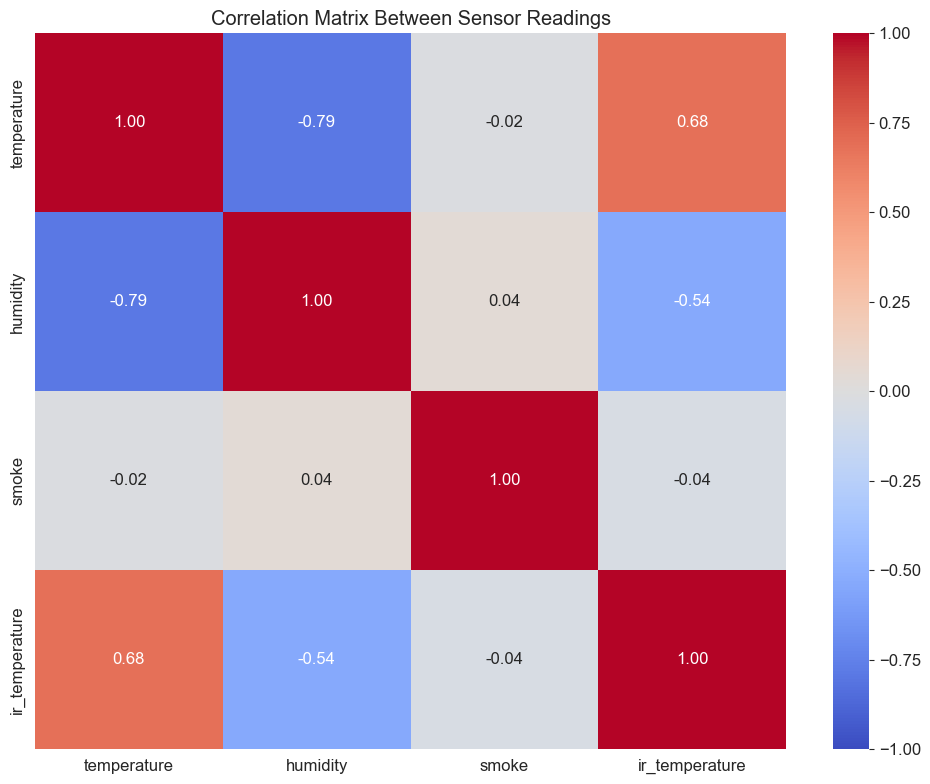

In [30]:
# Calculate correlation matrix
correlation_matrix = df4[numerical_columns].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Matrix Between Sensor Readings')
plt.tight_layout()
plt.show()

**Data Preparation for Sequence Modeling**




In [31]:
# Select the dataset to use - df5_downsampled has regular time intervals which is good for sequence modeling
print("Missing values in downsampled data:")
print(df5_downsampled.isnull().sum())

# Fill any remaining NaN values that might have been introduced during resampling
df_model = df5_downsampled.fillna(method='ffill').fillna(method='bfill')

# Display sample of prepared data
print("\nData ready for modeling:")
print(df_model.head())

Missing values in downsampled data:
temperature       185
humidity          185
smoke             185
ir_temperature    185
dtype: int64

Data ready for modeling:
                     temperature   humidity        smoke  ir_temperature
timestamp                                                               
2025-04-25 04:15:00    30.668421  85.736842  2183.666667       33.841931
2025-04-25 04:16:00    31.457143  83.800000  2105.600000       33.827716
2025-04-25 04:17:00    31.641176  82.852941  2035.852941       33.847644
2025-04-25 04:18:00    31.424138  81.310345  1962.327586       33.509312
2025-04-25 04:19:00    31.513793  80.551724  1922.103448       33.561384


**Scale the Data**

In [32]:
from sklearn.preprocessing import MinMaxScaler

# Initialize scalers dictionary to store a scaler for each feature
scalers = {}
scaled_data = pd.DataFrame(index=df_model.index)

# Scale each feature and store the scaler for inverse transformation later
for column in numerical_columns:
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data[column] = scaler.fit_transform(df_model[column].values.reshape(-1, 1)).flatten()
    scalers[column] = scaler

print("Original vs Scaled data sample:")
print(pd.concat([df_model.head(2), scaled_data.head(2)], keys=['Original', 'Scaled']))

Original vs Scaled data sample:
                              temperature   humidity        smoke  \
         timestamp                                                  
Original 2025-04-25 04:15:00    30.668421  85.736842  2183.666667   
         2025-04-25 04:16:00    31.457143  83.800000  2105.600000   
Scaled   2025-04-25 04:15:00     0.043989   0.962421     0.517140   
         2025-04-25 04:16:00     0.128347   0.898714     0.475723   

                              ir_temperature  
         timestamp                            
Original 2025-04-25 04:15:00       33.841931  
         2025-04-25 04:16:00       33.827716  
Scaled   2025-04-25 04:15:00        0.084147  
         2025-04-25 04:16:00        0.083952  


**Create Sequences for LSTM**

In [33]:
def create_sequences(data, target_column, sequence_length=24):
    """
    Create sequence of data for time series forecasting.

    Args:
        data: DataFrame containing all features
        target_column: Name of column to predict
        sequence_length: Number of time steps to look back

    Returns:
        X: Input sequences (lookback window)
        y: Target values (next timestep's value)
    """
    X, y = [], []

    for i in range(len(data) - sequence_length):
        # Input sequence (past time steps)
        seq_x = data.iloc[i:(i + sequence_length)].values
        # Target (next time step's value)
        seq_y = data.iloc[i + sequence_length][target_column]

        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)

# Define sequence length (how many time steps to look back)
SEQUENCE_LENGTH = 60  # 60-minute window (assuming 1-minute intervals in df5_downsampled)

# Dictionary to store sequences for each target variable
sequences = {}

# Create sequences for each target variable
for target in numerical_columns:
    X, y = create_sequences(scaled_data, target, SEQUENCE_LENGTH)
    sequences[target] = (X, y)
    print(f"For {target}: X shape = {X.shape}, y shape = {y.shape}")

For temperature: X shape = (6348, 60, 4), y shape = (6348,)
For humidity: X shape = (6348, 60, 4), y shape = (6348,)
For smoke: X shape = (6348, 60, 4), y shape = (6348,)
For ir_temperature: X shape = (6348, 60, 4), y shape = (6348,)


**Split Data into Train/Test Sets**

In [34]:
from sklearn.model_selection import train_test_split

# Dictionary to store train/test splits for each target
train_test_data = {}

# Create train/test splits for each target
for target in numerical_columns:
    X, y = sequences[target]

    # Split data (80% train, 20% test) - don't shuffle time series data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )

    train_test_data[target] = (X_train, X_test, y_train, y_test)

    print(f"For {target}:")
    print(f"  Training: X shape = {X_train.shape}, y shape = {y_train.shape}")
    print(f"  Testing:  X shape = {X_test.shape}, y shape = {y_test.shape}")

For temperature:
  Training: X shape = (5078, 60, 4), y shape = (5078,)
  Testing:  X shape = (1270, 60, 4), y shape = (1270,)
For humidity:
  Training: X shape = (5078, 60, 4), y shape = (5078,)
  Testing:  X shape = (1270, 60, 4), y shape = (1270,)
For smoke:
  Training: X shape = (5078, 60, 4), y shape = (5078,)
  Testing:  X shape = (1270, 60, 4), y shape = (1270,)
For ir_temperature:
  Training: X shape = (5078, 60, 4), y shape = (5078,)
  Testing:  X shape = (1270, 60, 4), y shape = (1270,)


**Define LSTM Model Function**

In [35]:
def create_lstm_model(input_shape):
    """
    Create an LSTM model for time series forecasting.

    Args:
        input_shape: Shape of input sequences (time_steps, features)

    Returns:
        Compiled Keras model
    """
    model = Sequential([
        # First LSTM layer with return sequences for stacking
        LSTM(100, activation='relu', return_sequences=True, input_shape=input_shape),

        # Second LSTM layer
        LSTM(50, activation='relu'),

        # Dropout for regularization
        Dropout(0.2),

        # Output layer for regression
        Dense(1)
    ])

    # Compile model with Adam optimizer and MSE loss
    model.compile(
        optimizer='adam',
        loss='mean_squared_error'
    )

    return model

**Train Models for Each Target Variable**

In [36]:
# Dictionary to store models and training history
models = {}
histories = {}

# Early stopping callback to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train a model for each target variable
for target in numerical_columns:
    print(f"\nTraining model for {target}...")

    # Get training data
    X_train, X_test, y_train, y_test = train_test_data[target]

    # Create and compile model
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = create_lstm_model(input_shape)

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=50,  # You can adjust this
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )

    # Store model and history
    models[target] = model
    histories[target] = history

    print(f"Model for {target} trained successfully!")


Training model for temperature...
Epoch 1/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0107 - val_loss: 9.9827e-04
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0020 - val_loss: 8.7191e-04
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0016 - val_loss: 7.7465e-04
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0017 - val_loss: 8.1423e-04
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0015 - val_loss: 6.9856e-04
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0013 - val_loss: 9.5687e-04
Epoch 7/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0013 - val_loss: 6.3220e-04
Epoch 8/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0012 - val_loss: 6.0505e-04
Epoch 9/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0012 - val_loss: 5.1039e-04
Epoch 10/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0010 - val_loss: 6.0035e-04
Epoch 11/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step 

**Evaluate Model Performance**

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

# Dictionary to store evaluation metrics
evaluation = {}

# Evaluate each model
for target in numerical_columns:
    print(f"\nEvaluating model for {target}...")

    # Get test data
    X_train, X_test, y_train, y_test = train_test_data[target]

    # Make predictions on test set (scaled)
    y_pred_scaled = models[target].predict(X_test)

    # Inverse transform predictions and actual values back to original scale
    y_pred = scalers[target].inverse_transform(y_pred_scaled)
    y_test_actual = scalers[target].inverse_transform(y_test.reshape(-1, 1))

    # Calculate metrics
    mse = mean_squared_error(y_test_actual, y_pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_test_actual, y_pred)
    r2 = r2_score(y_test_actual, y_pred)

    # Store evaluation metrics
    evaluation[target] = {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²: {r2:.4f}")


Evaluating model for temperature...
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
  MSE: 0.0641
  RMSE: 0.2531
  MAE: 0.1448
  R²: 0.9630

Evaluating model for humidity...
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
  MSE: 0.9823
  RMSE: 0.9911
  MAE: 0.5047
  R²: 0.8883

Evaluating model for smoke...
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
  MSE: 11003.0334
  RMSE: 104.8953
  MAE: 58.1277
  R²: 0.9012

Evaluating model for ir_temperature...
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
  MSE: 5.0336
  RMSE: 2.2436
  MAE: 0.3948
  R²: 0.3099


**Visualize Predictions vs. Actual Values**

In [38]:
import plotly.graph_objects as go

# Create visualizations for each target
for target in numerical_columns:
    # Get test data
    X_train, X_test, y_train, y_test = train_test_data[target]

    # Make predictions (scaled)
    y_pred_scaled = models[target].predict(X_test)

    # Inverse transform back to original scale
    y_pred = scalers[target].inverse_transform(y_pred_scaled).flatten()
    y_test_actual = scalers[target].inverse_transform(y_test.reshape(-1, 1)).flatten()

    # Create a DataFrame with actual and predicted values
    results_df = pd.DataFrame({
        'Actual': y_test_actual,
        'Predicted': y_pred
    }, index=df_model.index[-len(y_test):])

    # Plot with Plotly
    fig = go.Figure()

    # Add actual values trace
    fig.add_trace(
        go.Scatter(
            x=results_df.index,
            y=results_df['Actual'],
            mode='lines',
            name='Actual',
            line=dict(color='blue')
        )
    )

    # Add predicted values trace
    fig.add_trace(
        go.Scatter(
            x=results_df.index,
            y=results_df['Predicted'],
            mode='lines',
            name='Predicted',
            line=dict(color='red')
        )
    )

    # Update layout
    fig.update_layout(
        title=f'{target} - Actual vs Predicted Values',
        xaxis_title='Date',
        yaxis_title=target,
        legend=dict(x=0.01, y=0.99),
        width=1000,
        height=500
    )

    fig.show()

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


**Function for Making Future Predictions**

In [39]:
def forecast_future(model, last_sequence, scaler, n_steps=24):
    """
    Generate future forecasts.

    Args:
        model: Trained LSTM model
        last_sequence: Last known sequence from data (scaled)
        scaler: Scaler used for the target variable
        n_steps: Number of future steps to predict

    Returns:
        List of future predictions (in original scale)
    """
    future_predictions = []
    current_sequence = last_sequence.copy()

    # Make n_steps predictions
    for _ in range(n_steps):
        # Reshape for prediction
        current_batch = current_sequence.reshape(1, current_sequence.shape[0], current_sequence.shape[1])

        # Predict next value (returns scaled value)
        next_pred = model.predict(current_batch)[0]

        # Store prediction
        future_predictions.append(next_pred[0])

        # Update sequence: remove first timestep and add prediction as new timestep
        new_step = np.zeros(current_sequence.shape[1])
        for i in range(len(numerical_columns)):
            if i == numerical_columns.index(target):
                new_step[i] = next_pred
            else:
                # Keep previous values for non-target features (simplified approach)
                new_step[i] = current_sequence[-1, i]

        # Roll the sequence
        current_sequence = np.vstack([current_sequence[1:], new_step])

    # Convert scaled predictions back to original scale
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    future_predictions = scaler.inverse_transform(future_predictions)

    return future_predictions.flatten()

**Generate and Visualize Future Forecasts**

In [40]:
# Get the last sequence for prediction
last_idx = len(scaled_data) - SEQUENCE_LENGTH
forecast_sequence = scaled_data.iloc[last_idx:].values

# Number of future time steps to predict
future_steps = 24  # 24 hours ahead

# Create date range for future predictions
last_date = df_model.index[-1]
forecast_dates = pd.date_range(start=last_date, periods=future_steps+1, freq='1T')[1:]

# Dictionary to store future predictions
future_predictions = {}

# Generate predictions for each target
for target in numerical_columns:
    # Get target index
    target_idx = numerical_columns.index(target)

    # Get model and scaler
    model = models[target]
    scaler = scalers[target]

    # Generate future predictions
    pred = forecast_future(model, forecast_sequence, scaler, future_steps)

    # Store predictions
    future_predictions[target] = pred

# Create DataFrame with future predictions
future_df = pd.DataFrame(future_predictions, index=forecast_dates)

# Plot the historical data and future predictions for each target
for target in numerical_columns:
    # Create a figure
    fig = go.Figure()

    # Add historical data
    fig.add_trace(
        go.Scatter(
            x=df_model.index,
            y=df_model[target],
            mode='lines',
            name='Historical',
            line=dict(color='blue')
        )
    )

    # Add future predictions
    fig.add_trace(
        go.Scatter(
            x=future_df.index,
            y=future_df[target],
            mode='lines',
            name='Forecast',
            line=dict(color='red')
        )
    )

    # Add a vertical line to separate historical data from predictions
    # Convert timestamp to a format Plotly can handle
    fig.add_vline(
        x=df_model.index[-1].timestamp() * 1000,  # Convert to milliseconds for plotly
        line_dash="dash",
        line_color="green",
        annotation_text="Forecast Start"
    )

    # Update layout
    fig.update_layout(
        title=f'{target} - Historical and Forecast',
        xaxis_title='Date',
        yaxis_title=target,
        legend=dict(x=0.01, y=0.99),
        width=1000,
        height=500
    )

    fig.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

In [41]:
# Create directory for saving models
import os
model_dir = 'models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Save each model
for target in numerical_columns:
    model_path = os.path.join(model_dir, f'lstm_{target}_model.h5')
    models[target].save(model_path)
    print(f"Model for {target} saved to {model_path}")

Model for temperature saved to models\lstm_temperature_model.h5
Model for humidity saved to models\lstm_humidity_model.h5
Model for smoke saved to models\lstm_smoke_model.h5
Model for ir_temperature saved to models\lstm_ir_temperature_model.h5
